In [139]:
import pickle
import tqdm
import random

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [81]:
with open("matrix.pickle","rb") as f:
    matrix = pickle.load(f)

with open("test-public.txt","r") as f:
    test = f.readlines()

test_s = set()
test_d = set()
for l in test[1:]:
    temp = list(map(int, l.split()))
    test_s.add(temp[1]) ; test_d.add(temp[2])

In [82]:
print(len(test_s), len(test_d))

2000 1978


In [4]:
all_v = {}
for v in matrix:
    all_v[v] = all_v.get(v, 0) + 1
    for d in matrix[v]:
        all_v[d] = all_v.get(d, 0) + 1
print(len(all_v))

4867136


1978


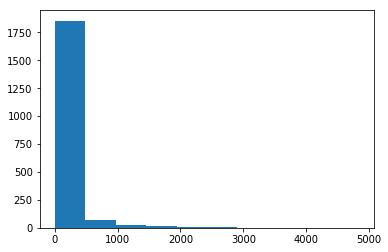

1
2
3
4
7
10
14
19
25
33
43
53
70
92
119
161
228
356
688


In [87]:
# indegree for sinks in test file
freq = []
for d in test_d:
    freq.append(all_v[d])
freq.sort()
print(len(freq))
plt.hist(freq)
plt.show()
for i in range(1, 20):
    print(freq[i*100-1])

In [90]:
all_freq = [n for n in list(all_v.values()) if n >= 2 and n <= 5000]

In [91]:
print(len([n for n in all_freq if n >= 1 and n <= 5])/len(all_freq))

0.6965739226303309


In [126]:
print(len([n for n in freq if 240 < n])/len(freq))

0.13346814964610718


In [ ]:
"""
sink distribution estimation

start         end    pmf    cdf
        x  <= 2   -- 0.15   0.15  
2    <  x  <= 6   -- 0.1    0.25  
6    <  x  <= 13  -- 0.1    0.35  
13   <  x  <= 25  -- 0.1    0.45  
25   <  x  <= 45  -- 0.1    0.55
45   <  x  <= 70  -- 0.1    0.65
70   <  x  <= 120 -- 0.1    0.75
120  <  x  <= 240 -- 0.1    0.85
240  <  x         -- 0.15   1  
"""

In [138]:
# divide vertices with indegrees

distri2v = {n:[] for n in range(9)}
v2distri = {}
for v in all_v:
    indegree = all_v[v]
    if indegree <= 2:
        distri2v[0].append(v)
        v2distri[v] = 0
    elif indegree <= 6:
        distri2v[1].append(v)
        v2distri[v] = 1
    elif indegree <= 13:
        distri2v[2].append(v)
        v2distri[v] = 2
    elif indegree <= 25:
        distri2v[3].append(v)
        v2distri[v] = 3
    elif indegree <= 45:
        distri2v[4].append(v)
        v2distri[v] = 4
    elif indegree <= 70:
        distri2v[5].append(v)
        v2distri[v] = 5
    elif indegree <= 120:
        distri2v[6].append(v)
        v2distri[v] = 6
    elif indegree <= 240:
        distri2v[7].append(v)
        v2distri[v] = 7
    else:
        distri2v[8].append(v)
        v2distri[v] = 8

In [144]:
# generate training data
# first sample real edges and record distribution

NUM_SAMPLE = 30000
source = list(matrix.keys())

data = []

distri = np.zeros(9)
pmf = np.array([0.15] + [0.1] * 7 + [0.15])
max_distri = pmf * NUM_SAMPLE

while len(data) < NUM_SAMPLE//2:
    src = random.choice(source)
    dest = random.sample(matrix[src], 1)[0]
    dest_distri = v2distri[dest]
    if distri[dest_distri] < max_distri[dest_distri]:
        distri[dest_distri] += 1
        data.append([src, dest, 1])

In [145]:
print(max_distri)
print(distri)

[4500. 3000. 3000. 3000. 3000. 3000. 3000. 3000. 4500.]
[2098. 1646. 1482. 1537. 1462. 1209. 1384. 1448. 2734.]


In [148]:
# sample fake edges and match test distribution

for i in range(len(pmf)):
    while distri[i] < max_distri[i]:
        src = random.choice(source)
        dest = random.choice(distri2v[i])
        if dest != src and dest not in matrix[src]:
            data.append([src, dest, 0])
            distri[i] += 1
random.shuffle(data)

In [149]:
print(max_distri)
print(distri)

[4500. 3000. 3000. 3000. 3000. 3000. 3000. 3000. 4500.]
[4500. 3000. 3000. 3000. 3000. 3000. 3000. 3000. 4500.]


In [153]:
with open("raw.pickle","wb") as f:
    pickle.dump(data, f)